First download the gear images using; 

* curl -O https://challenge.blob.core.windows.net/challengefiles/gear_images.zip
* unzip *.zip

Or in windows powershell;

* wget "https://challenge.blob.core.windows.net/challengefiles/gear_images.zip" -OutFile gear_images.zip
* unzip gear_images.zip

In [400]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle
from pipe import Pipe
from functools import reduce
import operator
from pipe import select,take,as_list
from sklearn import tree
from glob import glob
from PIL import Image
import numpy as np
import re

#Inline Matplot graphics into the notebook
%matplotlib inline 

def resizeImageToSquare(image, desiredSize):
    # old_size[0] is in (width, height) format
    oldSize = image.size

    ratio = float(desiredSize)/max(oldSize)
    newSize = tuple([int(x*ratio) for x in oldSize])

    image = image.resize(newSize, Image.BILINEAR)

    # create a new image and paste the resized on it
    resized = Image.new("L", (desiredSize, desiredSize), color=(255))
    resized.paste(image, ((desiredSize-newSize[0])//2,
                        (desiredSize-newSize[1])//2))
    return resized

* Load all the gear_images 
* Resize them to 128^2
* Make black and white (we don't want to learn particular colours of tents etc)
* Scale image numbers $\in [0,1]$

In [509]:
%%time

@Pipe
def as_npy(iterable):
    return np.array(iterable)

def getImageTypeFromPath(imagePath):
    return re.search('[^\w](\w+)[^\w]', imagePath)[1]

# note I have obfuscated the names so that people can not google the solutions
imageTypes = {
    'axes': 0, 
    'boots': 1, 
    'carabiners': 2,
    'crampons': 3, 
    'gloves': 4, 
    'hardshell_jackets': 5, 
    'harnesses': 6, 
    'helmets': 7, 
    'insulated_jackets': 8, 
    'pulleys': 9, 
    'rope': 10, 
    'tents': 11, 
}

imageTypesInverted = {v: k for k, v in imageTypes.items()}

def replaceBlack(t):
    t2 = t[1]
    t2[t2==0]=255
    return (t[0], t2)

xy = ( glob("gear_images/**/*")  
    | select(lambda path: (imageTypes[getImageTypeFromPath(path)], Image.open(path)))     
    # make black and white
    | select(lambda t: (t[0], t[1].convert('L') ) )     
    # make square
    | select(lambda t: (t[0], resizeImageToSquare(t[1], 128)) )     
    | select(lambda t: (t[0], np.array(t[1]))) 
    # replace blacks with white, about 1/50 images load with a black background
    # I have absolutley no idea why...
    | select(replaceBlack)   
    # scale to [0,1]
    | select(lambda t: (t[0], t[1] / 255))     
    | as_list() )

X = xy | select(lambda e: e[1]) | as_list() | as_npy()

# flattened version for classical learning
Xf = X.reshape( X.shape[0], reduce(operator.mul, X.shape[1:], 1)  )
y = xy | select(lambda e: e[0]) | as_list() | as_npy()

print("X", X.shape, "y", y.shape)

X (2122, 128, 128) y (2122,)
Wall time: 5.64 s


Let's plot some of the images so we can see what we are working with

In [418]:
def plotSome(x, y, name='axes'):
    fig = plt.figure(figsize=(8, 6))
    # plot several images
    for i in range(15):
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x[y==imageTypes[name]][i], cmap=plt.cm.bone)

from random import randint
        
def plot16(x, rand=False):
    fig = plt.figure(figsize=(8, 6))
    # plot several images
    for i in range(15):
        
        img = i
        if rand==True:
            img = randint(0,x.shape[0])
        
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        
        ax.imshow(x[img], cmap=plt.cm.bone)
        ax.set_xlabel(img)

Let's visually inspect our dataset by running this a few times, this is great for sanity checking and looking for bugs in how we parsed the images. I already noticed that some of the images were loading in with a black background, I have no idea why! I put a hacky line of code in the loader to fix this i.e. setting all 0=>255

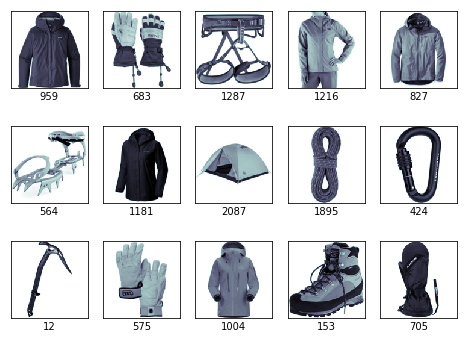

In [500]:
plot16(X, rand=True)

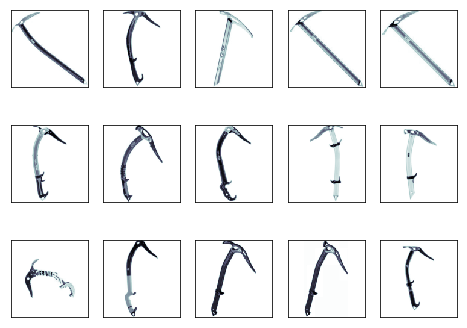

In [510]:
plotSome(X,y,'axes')

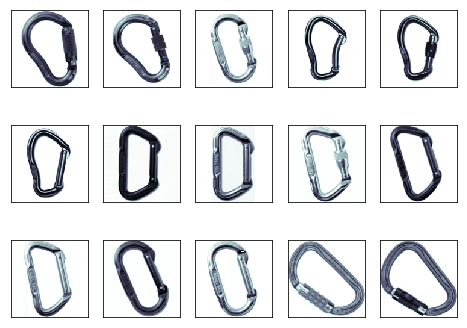

In [511]:
plotSome(X,y,'carabiners')

Let's try plotting one image for every class

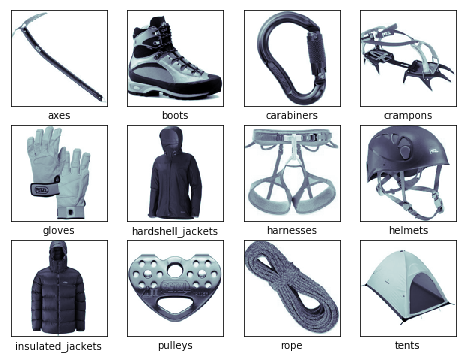

In [6]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X[y==imageTypes[key]][0], cmap=plt.cm.bone)
    ax.set_xlabel(key)
    i = i + 1

Let's get a bit more clever now and plot an average image for each class. The result is prettu instructive;

* We can see that roughly half of the boots are inverted
* In most cases there is a clear "signature" to the class, this is part of why this challenge is quite contrived, similar to the MNIST challenge, it should be possible to guess what the class is merely by choosing values for pixels in certain areas. 

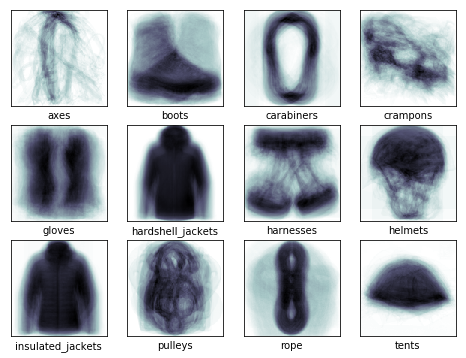

In [7]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X[y==imageTypes[key]].mean(axis=0), cmap=plt.cm.bone)
    ax.set_xlabel(key)
    i = i + 1

Let's split the data into a test and train set

In [610]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
        y, random_state=0)

print(X_train.shape, X_test.shape)

(1591, 128, 128) (531, 128, 128)


Helper function to convert label indexes i.e. {0,1,2...} into labels i.e. {"axes","carabiners"...}

In [43]:
def ConvertIndexToLabel(indexes):
    return list( indexes ) | select( lambda i: imageTypesInverted[i] ) | as_list 

Here is a function which let's us plot a nice confusion matrix

In [45]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plotConfusion(yy, p, title='Confusion matrix'):
    cnf_matrix = metrics.confusion_matrix(yy, p)
    np.set_printoptions(precision=2)

    cm_labels = list(set(imageTypes.keys()))
    cm_labels.sort()

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                          title=title)

What is the average image over everything?

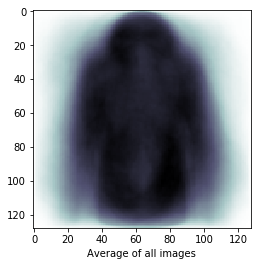

In [9]:
def PlotAverageImage(D):
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    plt.imshow(D.mean(axis=0), cmap=plt.cm.bone)
    u = plt.xlabel( f"Average of all images" ) 

PlotAverageImage(X)

Jackets seem to be dominating, could this be because;

* The intensity values are higher in jackets
* There are more jackets overall (remember insulated jackets + normal jackets)


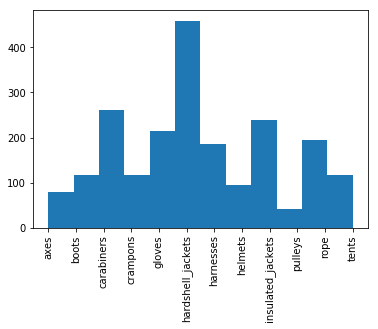

In [10]:
u = plt.hist(y, bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

It does indeed appear that our hardshell jackets are dominating due to there being many more of them, also the jackets are around 200 and will have a similar profile which will compound the problem

Let's balance the distribution of classes by supersampling in the *train* split. It's important we don't do this on the test split too, as there would be many duplicate images in the test set and it would be trivial to memorise what they are. 

In [722]:
from pipe import chain, as_dict, Pipe, select, take, as_list

@Pipe
def pcycle(iterable):
    while True:
        for it in iterable:
            yield it
        
@Pipe
def as_npy(iterable):
    return np.array(iterable)

def balancedSignalGenerator(X,y,num_classes=12):
    
    class_map = {}
    for c in range(num_classes):
        class_map[c] = list(np.where( y==c)[0])
                            
    D = range(num_classes) \
        | select( lambda c: class_map[c] | pcycle | select( lambda i: (c,X[i]) )  ) \
        | as_list

    while True:
        for c in D:
            yield next(c)[0], next(c)[1]

        
data = balancedSignalGenerator(X_train,y_train) | take(4200) | as_list

# note that we need as_list on the data
X_train_bal = data | select(lambda el: el[1])  | as_list | as_npy
y_train_bal = data | select(lambda el: el[0])  | as_list | as_npy

In [723]:
print( X_train_bal.shape, y_train_bal.shape )

(4200, 128, 128) (4200,)


And we are now balanced!

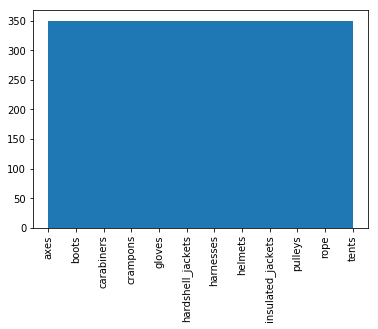

In [51]:
plt.hist(y_train_bal,bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

Now, let's plot the average image again. This looks a little bit more reasonable i.e. there is a consistent "contribution" to the mixture from all 12 classes. If anything it's now the rope which is slightly dominating, I assume because its being "boosted" from mixing with the jackets which entirely intersect. 

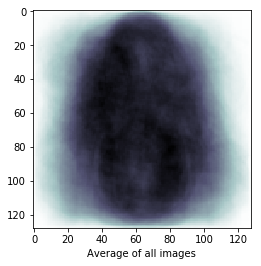

In [52]:
PlotAverageImage(X_train_bal)

Let's look at the intensity histogram for each class average. This is interesting;


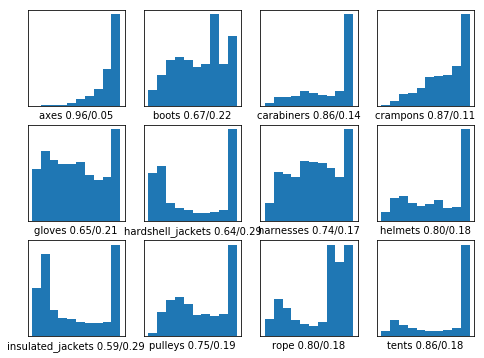

In [527]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    ax.hist(x)
    ax.set_xlabel( f"{key} {x.mean():.2f}/{x.std():.2f}" ) 
    i = i + 1

One of the key goals in vision, is transforming the data out of the space domain. In the olden days of computer vision, the onus was on the data scientists themselves to transform the data out of the space domain using some feature. This histogram technique is the most basic version of that. 


* Classical algorithms can not learn any spatial relationship or local pattern between the pixels and the assumption is that images are typically taken from a variety of angles/environments which *should* render pixel-by-pixel mapping methods unworkable. 
* Images are sparse and statistically undescriptive
* We experience the "curse of dimensionality" problem working with images on classical methods


Let's look at these histograms; while there are some differences between the classes, clearly the previous (2d spatial) information is more instructive to seperate the class. We can tell this just with visual inspection. Let's close the loop on this one though and build a classifier using these histograms as feature vectors. 

In [528]:
def getHistFeatures(D, bins=20):
    
    n = D.shape[0]
    
    Xf = D.reshape(n,128*128)
    
    x = np.zeros( (n, bins))
    
    for i in range( n ):
        hist, _ = np.histogram(Xf[i], bins=bins)
        
        x[i] = hist
        
    x = x / np.max(np.max(x))
    
    return x

bins = 20
Xh_train_bal = getHistFeatures(X_train_bal, bins=bins)
Xh_test = getHistFeatures(X_test, bins=bins)

print(Xh_train_bal.shape, Xh_test.shape)

(4200, 20) (531, 20)


Basic Trees algorithm (ID3) function

In [529]:
from sklearn import tree
from sklearn import metrics

def flattenImage(I, dim=128):
    if len(I.shape)>3:
        return I.reshape(I.shape[0], dim*dim, 3)
    else:
        return I.reshape(I.shape[0], dim*dim)

# expects flattened data going in
def ID3(xtr,xte,ytr,yte, title="confusion"):
    classifier = tree.DecisionTreeClassifier()
    clf = classifier.fit(xtr, ytr)
    p = clf.predict(xte)
    print(
        metrics.classification_report(
            ConvertIndexToLabel(yte), 
            ConvertIndexToLabel(p)
        ))
    plotConfusion(yte, p, title=title)
    return p, clf


So we have now transformed our (1591, 128, 128) image data into (1591, 20) i.e. instead of $128^2$ pixel values, we have $20$ discrete bins of intensity values. We have also scaled the data $\in [0,1]$ Let's run ID3 (trees) and see what we get

                   precision    recall  f1-score   support

             axes       0.90      1.00      0.95        28
            boots       0.41      0.41      0.41        22
       carabiners       0.59      0.78      0.67        63
         crampons       0.73      0.50      0.59        38
           gloves       0.44      0.31      0.37        51
hardshell_jackets       0.60      0.75      0.66       106
        harnesses       0.68      0.76      0.72        45
          helmets       0.33      0.42      0.37        24
insulated_jackets       0.57      0.37      0.45        68
          pulleys       0.20      0.14      0.17        14
             rope       0.59      0.67      0.63        43
            tents       0.50      0.31      0.38        29

      avg / total       0.58      0.58      0.57       531

Wall time: 133 ms


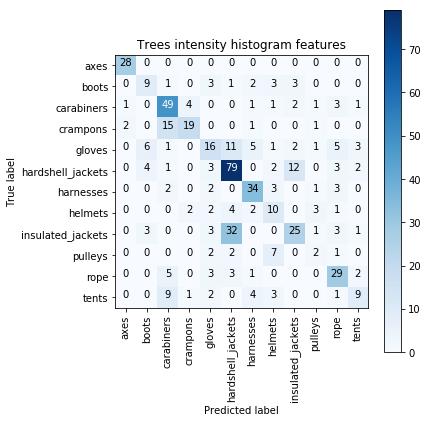

In [684]:
%%time
y_pred = ID3( Xh_train_bal, Xh_test, y_train_bal, y_test, title='Trees intensity histogram features' )

Surprisingly, this isn't too bad! Clearly though we lose a lot of information by transforming out of the space domain in this way. 

Let's run a basic decision tree algorithm on the images (balanced train set) on the raw pixels i.e. ID3 algorithm

                   precision    recall  f1-score   support

             axes       0.82      0.82      0.82        28
            boots       0.64      0.82      0.72        22
       carabiners       0.83      0.79      0.81        63
         crampons       0.78      0.55      0.65        38
           gloves       0.66      0.61      0.63        51
hardshell_jackets       0.67      0.77      0.72       106
        harnesses       0.75      0.67      0.71        45
          helmets       0.61      0.71      0.65        24
insulated_jackets       0.59      0.38      0.46        68
          pulleys       0.18      0.14      0.16        14
             rope       0.57      0.91      0.70        43
            tents       0.86      0.83      0.84        29

      avg / total       0.69      0.68      0.68       531

Wall time: 19.6 s


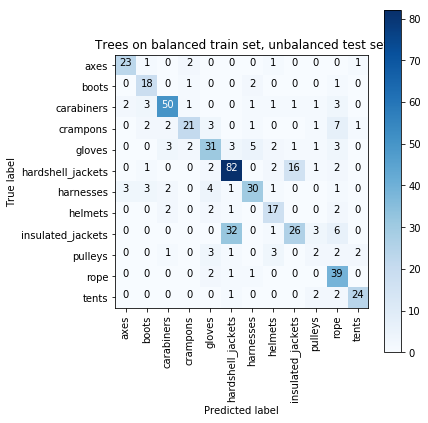

In [531]:
%%time
y_pred, clf = ID3( 
    flattenImage(X_train_bal), 
    flattenImage(X_test), 
    y_train_bal, 
    y_test, 
    title='Trees on balanced train set, unbalanced test set' )

We get about ~.71 f-1 on this which to be clear is training on the supersampled train split and tested on the original test split. The confusion matrix; clearly the biggest problem is confusing the two jacket classes. But surprisingly, this isn't too bad either. It is better to model the raw pixels right now than the histogram features. 

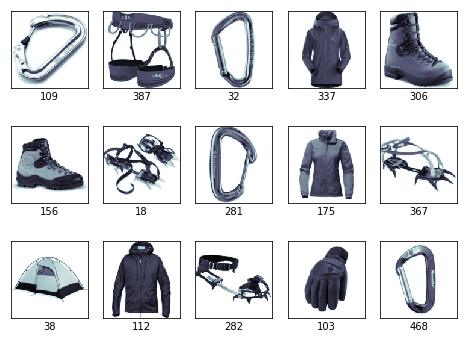

In [545]:
plot16(X_test, rand=True)

Other approaches work to try and transform out of the larger, sparse space domain while retaining some spatial information. An example of this is histogram of gradients (HoG) 

(8100,)


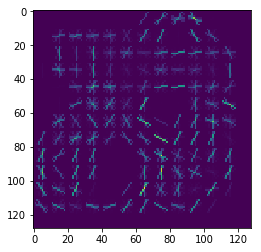

In [159]:
from skimage.feature import hog

fd, hogimage = hog(X_train_bal[30], block_norm='L2-Hys', visualise=True, cells_per_block=(10,10), pixels_per_cell=(10,10))

plt.imshow(hogimage)

print(fd.shape)

In [631]:
%%time

def computeHogFeatures(x):
    n = x.shape[0]
    
    Xhog = np.zeros( (n, 8100) )

    for i in range(n):
        Xhog[i] = hog(x[i], block_norm='L2-Hys', cells_per_block=(10,10), pixels_per_cell=(10,10))
        
    return Xhog

X_train_bal_hog = computeHogFeatures(X_train_bal)
X_test_bal_hog = computeHogFeatures(X_test)

Wall time: 11.7 s


SVM reusable function;

In [583]:
from sklearn import svm
    
def SVM(xtr, xte, ytr, yte, title="confusion matrix", C=10., gamma=0.001):
    clf = svm.SVC(C=C, kernel='rbf', gamma=gamma)
    clf.fit(xtr, ytr)
    y_pred = clf.predict(xte)
    print(metrics.classification_report(ConvertIndexToLabel(yte), ConvertIndexToLabel(y_pred)))
    plotConfusion(yte, y_pred, title=title)
    return y_pred, clf

Now let's run an SVM on the hog features (turns out this is actually really bad, PCA didn't help)

                   precision    recall  f1-score   support

             axes       0.12      0.50      0.19        28
            boots       0.76      0.59      0.67        22
       carabiners       0.37      0.83      0.51        63
         crampons       0.00      0.00      0.00        38
           gloves       0.70      0.31      0.43        51
hardshell_jackets       1.00      0.06      0.11       106
        harnesses       0.35      0.78      0.48        45
          helmets       0.80      0.33      0.47        24
insulated_jackets       0.94      0.24      0.38        68
          pulleys       0.00      0.00      0.00        14
             rope       0.10      0.07      0.08        43
            tents       0.75      0.10      0.18        29

      avg / total       0.58      0.31      0.29       531

Wall time: 1min 5s


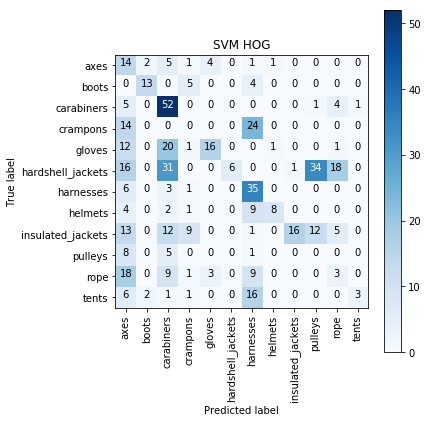

In [673]:
%%time
y_pred = SVM(X_train_bal_hog, X_test_bal_hog, y_train_bal, y_test, title='SVM HOG', C=25, gamma=0.001)

PCA helper function

In [677]:
from sklearn import decomposition

def PCA(xtr, xte, n_components=50, flat_size = 128*128):
    
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(xtr.reshape(xtr.shape[0],flat_size))

    xtr_pca = pca.transform(xtr.reshape(xtr.shape[0],flat_size))
    xte_pca = pca.transform(xte.reshape(xte.shape[0],flat_size))
    
    return xtr_pca, xte_pca, pca
    

Let's try PCA on the raw pixels + SVM

                   precision    recall  f1-score   support

             axes       1.00      0.93      0.96        28
            boots       1.00      0.95      0.98        22
       carabiners       0.93      0.98      0.95        63
         crampons       0.89      0.89      0.89        38
           gloves       0.92      0.92      0.92        51
hardshell_jackets       0.83      0.90      0.86       106
        harnesses       1.00      0.96      0.98        45
          helmets       0.92      0.92      0.92        24
insulated_jackets       0.83      0.74      0.78        68
          pulleys       1.00      0.50      0.67        14
             rope       0.81      0.98      0.88        43
            tents       1.00      0.97      0.98        29

      avg / total       0.90      0.90      0.90       531

Wall time: 3.41 s


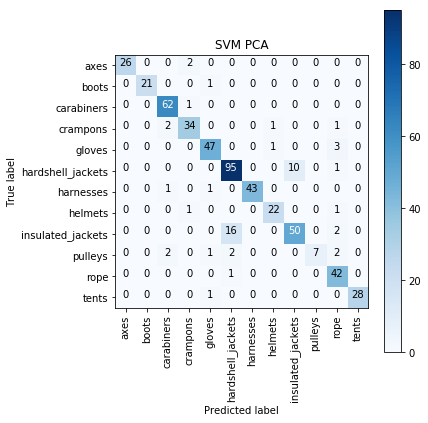

In [725]:
%%time

X_train_bal_pca, X_test_bal_pca, _ = PCA(X_train_bal, X_test, n_components=40)

y_pred, model = SVM(X_train_bal_pca, 
                    X_test_bal_pca, 
                    y_train_bal, 
                    y_test, 
                    title='SVM PCA', 
                    C=20, 
                    gamma=0.001)

In [691]:
X_train_bal.shape

(4200, 128, 128)

Now let's add some white noise to the backgrounds, the hypothesis on the table is that it's just learning where the white pixels are...

In [726]:
%%time

from random import uniform
from pipe import take, select, as_list, Pipe

import random

@Pipe
def pshuffle(l):
    random.shuffle(l)
    return l

def noiseImages( images ):
    images_whitenoise = images

    mask = images_whitenoise>0.95
    vals = range(np.count_nonzero(mask)) | select( lambda n: uniform(0, 1)) | as_list()

    # Assign back into X
    images_whitenoise[mask] = vals
    return images_whitenoise
    
X_test_whitenoise = noiseImages( X_test )
X_train_bal_whitenoise = noiseImages( X_train_bal )

Wall time: 24 s


And let's plot 16 test images to see if the backgrounds have been noised

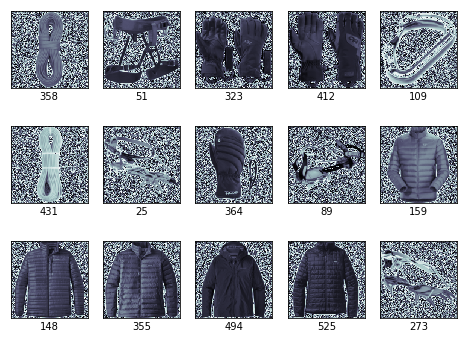

In [727]:
plot16(X_test_whitenoise, rand=True)

Now let's run trees (ID3) on noisy images, we are expecting the accuracy to plummet

In [22]:
print(X_train_bal_whitenoise.shape, X_test_whitenoise.shape, y_train_bal.shape, y_test.shape)

(4200, 128, 128) (531, 128, 128) (4200,) (531,)


                   precision    recall  f1-score   support

             axes       0.02      0.04      0.03        28
            boots       0.34      0.50      0.41        22
       carabiners       0.34      0.32      0.33        63
         crampons       0.20      0.11      0.14        38
           gloves       0.40      0.41      0.40        51
hardshell_jackets       0.51      0.58      0.54       106
        harnesses       0.30      0.27      0.28        45
          helmets       0.24      0.33      0.28        24
insulated_jackets       0.43      0.29      0.35        68
          pulleys       0.20      0.07      0.11        14
             rope       0.35      0.35      0.35        43
            tents       0.25      0.31      0.28        29

      avg / total       0.35      0.34      0.34       531

Wall time: 1min 6s


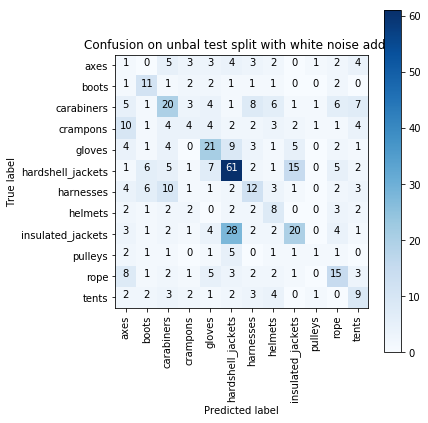

In [729]:
%%time

y_pred = ID3(flattenImage(X_train_bal_whitenoise), 
             flattenImage(X_test_whitenoise), 
             y_train_bal, y_test, title='Confusion on unbal test split with white noise added')

And indeed, the accuracy plumets to ~.34 average f-1 score!! Ouch.

It's now shockingly bad on axes, helmets and pulleys, let's look at the confusion matrix.

Pretty bad across the board but what we do see is that it works much better on hardshell jackets! This is pretty much because we have more hardshell jackets than any other class, so the classifier can "guess" hardshell jackets more often. We now have three things we can do to address this;

* Supersample the test set so that the label distribution is balanced like the training set, this would result in many duplicate images
* Subsample the test set so that the label distribution is balanced, this would result in a much smaller set
* Supersample the test set with augmentation i.e. random translations, scale/rotation transforms (maybe even affine). 

There are tradeoffs here. The first option will effectively be testing over many of the same images which might constitute cheating. The second option would result in a much smaller sample. The third option is safer but would destroy classical methods like trees which perform pixel mapping. We want to do augmentation anyway soon to demonstrate this. 

First, let's supersample the test set and renoise, and see what we get

                   precision    recall  f1-score   support

             axes       0.14      0.22      0.17       100
            boots       0.37      0.37      0.37       100
       carabiners       0.25      0.32      0.28       100
         crampons       0.13      0.06      0.08       100
           gloves       0.36      0.41      0.38       100
hardshell_jackets       0.31      0.58      0.40       100
        harnesses       0.26      0.22      0.24       100
          helmets       0.36      0.35      0.36       100
insulated_jackets       0.41      0.21      0.28       100
          pulleys       0.00      0.00      0.00       100
             rope       0.36      0.38      0.37       100
            tents       0.36      0.37      0.36       100

      avg / total       0.28      0.29      0.27      1200

Wall time: 1min 6s


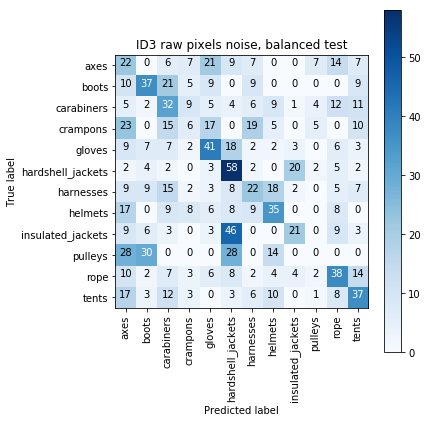

In [730]:
%%time
data = balancedSignalGenerator(X_test,y_test) | take(1200) | as_list

X_test_bal = data | select(lambda el: el[1])  | as_list | as_npy
y_test_bal = data | select(lambda el: el[0])  | as_list | as_npy

X_test_bal_whitenoise = noiseImages( X_test_bal )

y_pred = ID3(flattenImage(X_train_bal_whitenoise), 
                     flattenImage(X_test_bal_whitenoise), y_train_bal, y_test_bal, title="ID3 raw pixels noise, balanced test")

This is interesting, so the F-1 score is similar but the results are way more balanced i.e. the confusion matrix is telling a much better story and we can actually intepret what is being confused with what

There is a problem in classical ML approaches called the *Curse of Dimensionality* where classifiers tend to overfit the training data in high dimensional spaces, especially when there are more dimensions as there are examples. Deep learning doesn't suffer from this problem because the data is usually larger, and that deep learning algorithms learn a lower dimensional intermediate representation as part of the training process which might have different activations for sparse patterns in the input data and also learn a spatial manifold to transform the data. 

Algorithms like SVM for example in the dual formulation are somewhat resistant to the curse of dimensionality because it transforms the data into an implied higher dimensional space by computing the $N \times N$ $XX'$ matrix i.e. where $N$ is the number of examples. This means that the space complexity is a function of $N$, not $L$ (the number of attributes). Of course in this situation, $L$ is still $~2200$ which means we have about $5$ million bytes.  

In classical ML, the more features you add past a point, the worse the performance gets;

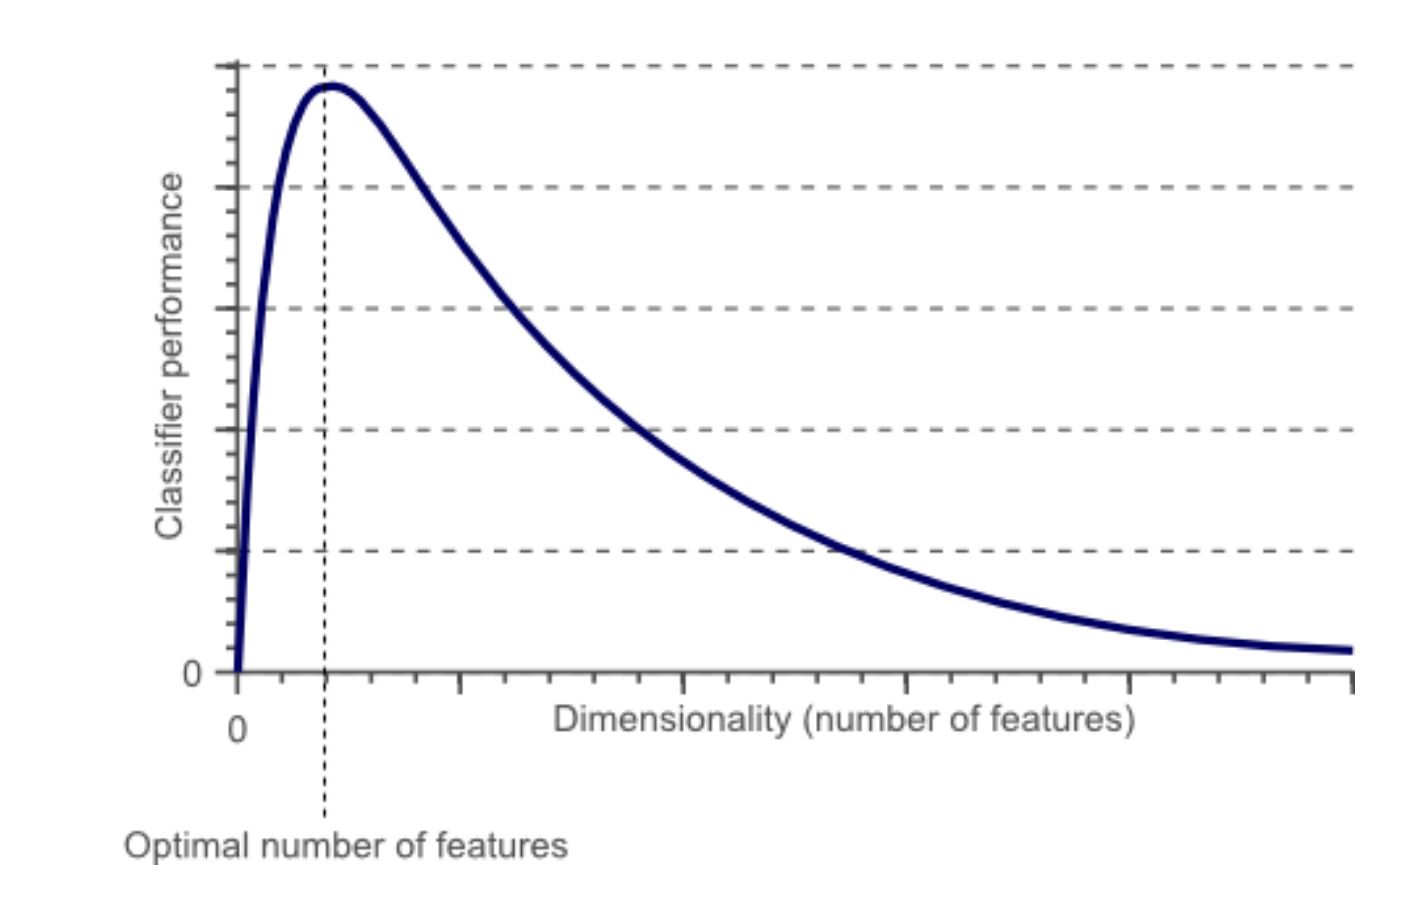

(image from http://www.visiondummy.com/2014/05/feature-extraction-using-pca/#PCA_pitfalls)

Of course, in this application every single pixel is a feature, which means we have $128^2$ features which is $\gt10000$! It means we have significantly more features than we do signals. 

An approach people use in these circumstances with classical algorithms is to use PCA to reduce the dimensionality first. 

Signals are often redundant because they are statistically dependent (correlated). PCA transforms the data into a set of uncorrelated components, allowing you to focus on the most significant components without losing any information about them. 

PCA computes the eigen vectors of the covariance matrix of $X$ and then projects the data onto those vectors. This still makes some assumption about the absolute pixel positions of images i.e. if they are all shifted, there would be less correlation between the dimensions. PCA is good because it;

* Captures the correlation if there is any and projects into decorrelated features
* Removes noise
* Helps with the curse of dimensionality

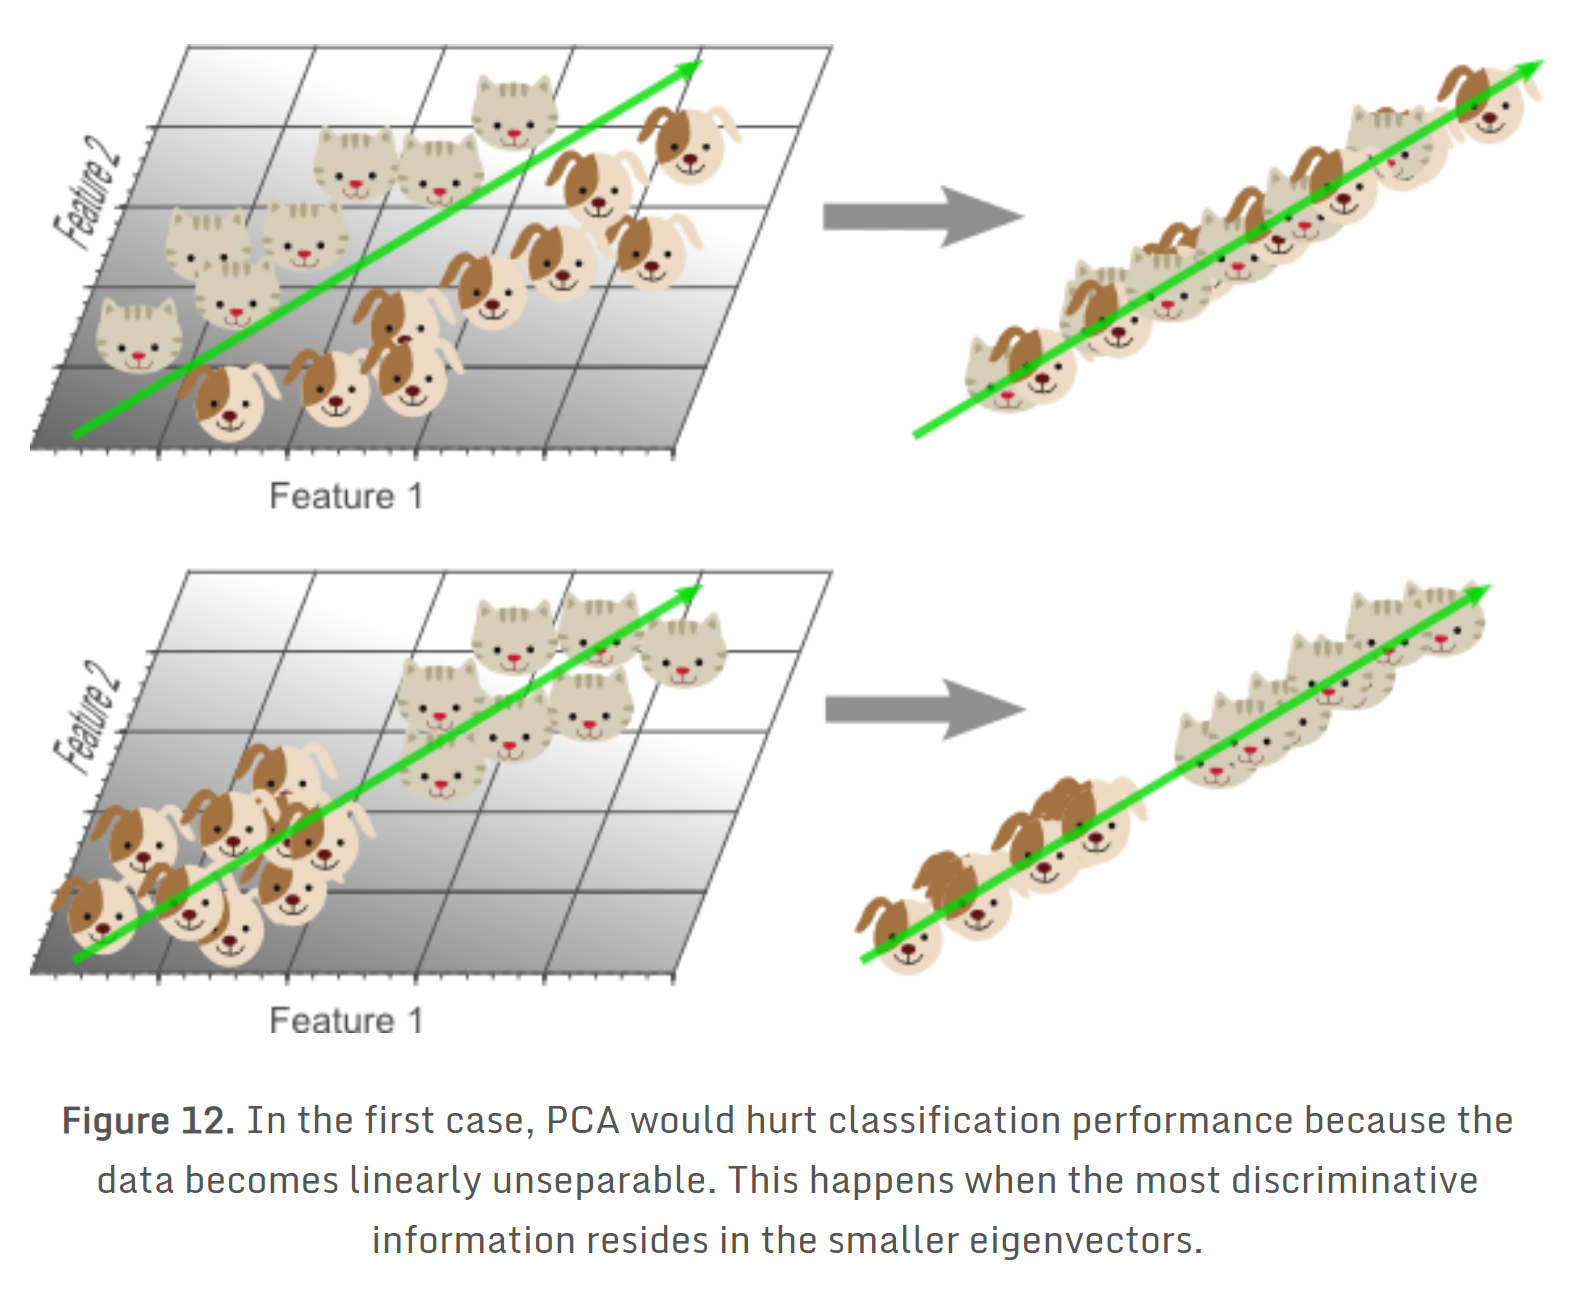




In this case, other dimensionality reduction methods might be of interest, such as Linear Discriminant Analysis (LDA) which tries to find the projection vector that optimally separates the two classes.

PCA would clearly help here because all the images are scaled and frontalised the same. So in that sense it actually helps "transforming the data out of the space domain" by learning correlations between pixels fixed in space. If the images were "all over the place" and subject to random transformations (augmentations); PCA would only help in this respect where there was some accidental consistency of overlap.

In [731]:
X_train_bal_whitenoise_pca, X_test_bal_whitenoise_pca, pca = PCA(X_train_bal_whitenoise, X_test_bal_whitenoise)

Let's visualise the first principal components

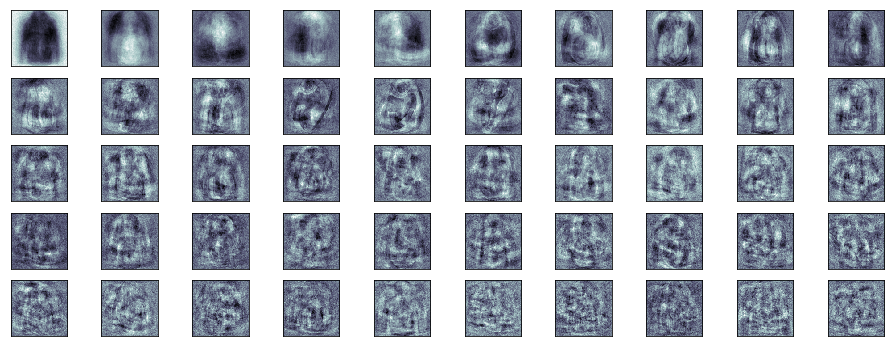

In [732]:
fig = plt.figure(figsize=(16, 6))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(128,128),
              cmap=plt.cm.bone)

What we observe here is that the principal component do not magically transform the data out of the space domain -- the x/y dimensions are still highly relevant. But it does show us something about the variance between pixels accross classes i.e. we can start to see the shapes of different items

Let's try running an SVM on the PCA data

                   precision    recall  f1-score   support

             axes       0.53      0.90      0.67       100
            boots       0.83      0.91      0.87       100
       carabiners       0.49      0.76      0.59       100
         crampons       0.86      0.61      0.71       100
           gloves       0.76      0.78      0.77       100
hardshell_jackets       0.55      0.85      0.67       100
        harnesses       0.95      0.63      0.76       100
          helmets       0.84      0.73      0.78       100
insulated_jackets       0.83      0.57      0.67       100
          pulleys       1.00      0.14      0.25       100
             rope       0.66      0.77      0.71       100
            tents       0.78      0.66      0.71       100

      avg / total       0.76      0.69      0.68      1200

Wall time: 752 ms


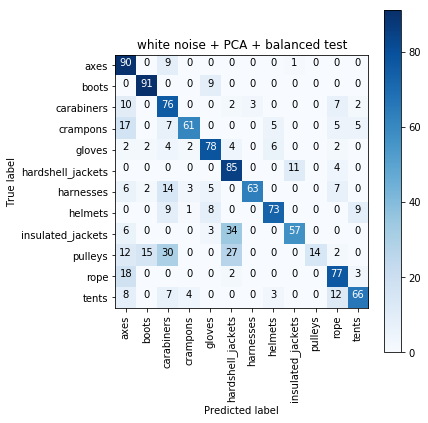

In [734]:
%%time
y_pred = SVM(X_train_bal_whitenoise_pca, X_test_bal_whitenoise_pca, y_train_bal, y_test_bal, title="white noise + PCA + balanced test")

It is actually a significant improvement i.e. f-1 improves from .27->.49

Now that we have only 50 features, it's computationally tractable to run something like an SVM, let's try that

                   precision    recall  f1-score   support

             axes       0.50      0.76      0.60       100
            boots       0.89      0.91      0.90       100
       carabiners       0.45      0.85      0.59       100
         crampons       0.86      0.60      0.71       100
           gloves       0.77      0.82      0.80       100
hardshell_jackets       0.54      0.90      0.68       100
        harnesses       0.86      0.64      0.74       100
          helmets       0.82      0.58      0.68       100
insulated_jackets       0.88      0.60      0.71       100
          pulleys       1.00      0.14      0.25       100
             rope       0.71      0.78      0.74       100
            tents       0.94      0.75      0.83       100

      avg / total       0.77      0.69      0.69      1200



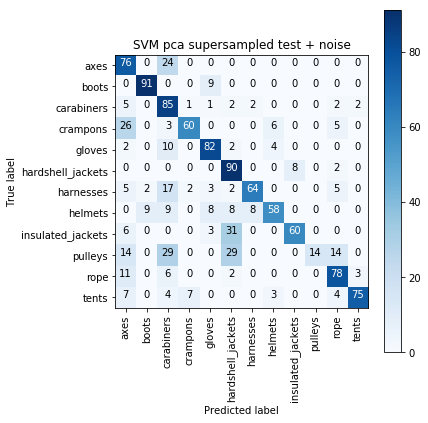

In [28]:
from sklearn import svm
clf = svm.SVC(C=10., kernel='rbf', gamma=0.001)
clf.fit(X_train_bal_whitenoise_pca, y_train_bal)
y_pred = clf.predict(X_test_bal_whitenoise_pca)
print(metrics.classification_report(ConvertIndexToLabel(y_test_bal), ConvertIndexToLabel(y_pred)))
plotConfusion(y_test_bal, y_pred, title='SVM pca supersampled test + noise')

This is actually pretty good we went from .49 on trees to .69 here with SVM, performing very well on boots and badly on pulleys axes and carabiners, some confusion between the jackets. 

The hypothesis on the table is that a CNN would work better because it can model local spatial patterns which are somewhat invariant to translation

First to use a CNN we need to add an explicit colour channel back in, even if it's only 1, also we need to one-hot encode the labels

Train on 4200 samples, validate on 1200 samples
Epoch 1/30
4200/4200 [==============================] - 2s 480us/step - loss: 1.4924 - acc: 0.5221 - val_loss: 0.6276 - val_acc: 0.8083
Epoch 2/30
4200/4200 [==============================] - 1s 345us/step - loss: 0.5264 - acc: 0.8281 - val_loss: 0.4089 - val_acc: 0.8492
Epoch 3/30
4200/4200 [==============================] - 1s 345us/step - loss: 0.2996 - acc: 0.8950 - val_loss: 0.4051 - val_acc: 0.8533
Epoch 4/30
4200/4200 [==============================] - 1s 346us/step - loss: 0.2082 - acc: 0.9245 - val_loss: 0.3529 - val_acc: 0.8717
Epoch 5/30
4200/4200 [==============================] - 1s 348us/step - loss: 0.1587 - acc: 0.9424 - val_loss: 0.2862 - val_acc: 0.8800
Epoch 6/30
4200/4200 [==============================] - 1s 351us/step - loss: 0.0985 - acc: 0.9698 - val_loss: 0.2724 - val_acc: 0.9100
Epoch 7/30
4200/4200 [==============================] - 1s 345us/step - loss: 0.0759 - acc: 0.9743 - val_loss: 0.2652 - val_acc: 0.9183


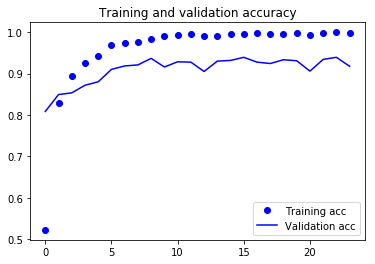

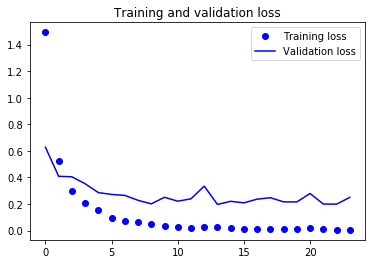

In [661]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

def addColourDimension(x):
    return x.reshape(x.shape[0],128,128,1)

def plotHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
def runCNNModel( xtr, xte, ytr, yte, epochs=5, batchsize=100, dropout=0.4 ):
    
    xtr_1 = addColourDimension(xtr)
    xte_1 = addColourDimension(xte)
    ytr_1 = to_categorical(ytr, num_classes=12)
    yte_1 = to_categorical(yte, num_classes=12)
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(12, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [ EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=10, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        # this will restore the best weights back to the model
        restore_best_weights=True) ]
    
    #train the model
    history = model.fit(xtr_1, ytr_1, 
                        epochs=epochs, batch_size=batchsize, 
                        validation_data=(xte_1, yte_1),
                        callbacks=callbacks)
    
    plotHistory(history)
    
    return history, model

history, model = runCNNModel(
    X_train_bal_whitenoise,
    X_test_bal,
    y_train_bal,
    y_test_bal, epochs=30, batchsize=200, dropout=0.6)

                   precision    recall  f1-score   support

             axes       0.97      1.00      0.99       100
            boots       0.98      0.91      0.94       100
       carabiners       0.98      0.94      0.96       100
         crampons       0.94      0.97      0.96       100
           gloves       0.77      0.96      0.85       100
hardshell_jackets       0.81      0.95      0.88       100
        harnesses       1.00      0.92      0.96       100
          helmets       1.00      1.00      1.00       100
insulated_jackets       0.88      0.91      0.90       100
          pulleys       1.00      0.71      0.83       100
             rope       0.92      0.95      0.94       100
            tents       1.00      0.94      0.97       100

      avg / total       0.94      0.93      0.93      1200



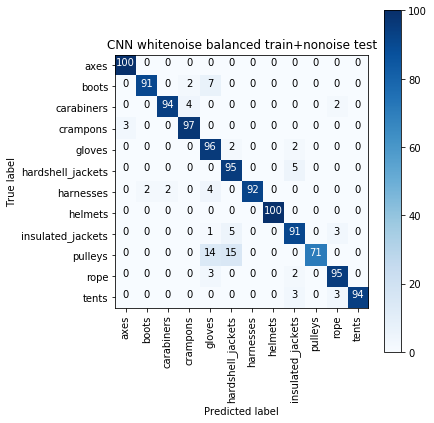

In [666]:
from numpy import argmax

def CNNEvaluate(model, xte,yte,title=''):
    y_pred = model.predict(addColourDimension(xte))
    print(metrics.classification_report(ConvertIndexToLabel(yte), ConvertIndexToLabel(argmax(y_pred,axis=1))))
    plotConfusion(yte, argmax(y_pred,axis=1), title=title)

CNNEvaluate(model,X_test_bal,y_test_bal, title='CNN whitenoise balanced train+nonoise test')

What if we run the CNN on the pre-noise data?

Train on 4200 samples, validate on 1200 samples
Epoch 1/30
4200/4200 [==============================] - 2s 498us/step - loss: 1.7284 - acc: 0.4452 - val_loss: 0.7596 - val_acc: 0.7267
Epoch 2/30
4200/4200 [==============================] - 1s 341us/step - loss: 0.5412 - acc: 0.8162 - val_loss: 0.4427 - val_acc: 0.8625
Epoch 3/30
4200/4200 [==============================] - 1s 342us/step - loss: 0.3407 - acc: 0.8817 - val_loss: 0.3166 - val_acc: 0.8792
Epoch 4/30
4200/4200 [==============================] - 1s 341us/step - loss: 0.2384 - acc: 0.9079 - val_loss: 0.3144 - val_acc: 0.8767
Epoch 5/30
4200/4200 [==============================] - 1s 343us/step - loss: 0.1501 - acc: 0.9486 - val_loss: 0.2669 - val_acc: 0.9067
Epoch 6/30
4200/4200 [==============================] - 1s 345us/step - loss: 0.1029 - acc: 0.9655 - val_loss: 0.2167 - val_acc: 0.9250
Epoch 7/30
4200/4200 [==============================] - 1s 343us/step - loss: 0.0793 - acc: 0.9729 - val_loss: 0.2228 - val_acc: 0.9225


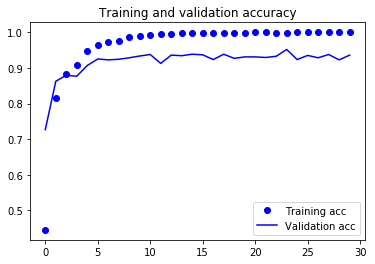

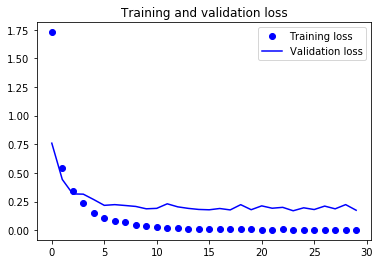

In [736]:
history, model = runCNNModel(
    X_train_bal,
    X_test_bal,
    y_train_bal,
    y_test_bal, epochs=30, batchsize=200, dropout=0.6)

                   precision    recall  f1-score   support

             axes       0.95      1.00      0.98       100
            boots       0.98      1.00      0.99       100
       carabiners       0.98      0.94      0.96       100
         crampons       0.96      0.95      0.95       100
           gloves       0.87      0.92      0.89       100
hardshell_jackets       0.83      0.95      0.88       100
        harnesses       1.00      0.96      0.98       100
          helmets       0.98      0.91      0.94       100
insulated_jackets       0.93      0.94      0.94       100
          pulleys       1.00      0.71      0.83       100
             rope       0.82      0.98      0.89       100
            tents       1.00      0.97      0.98       100

      avg / total       0.94      0.94      0.94      1200



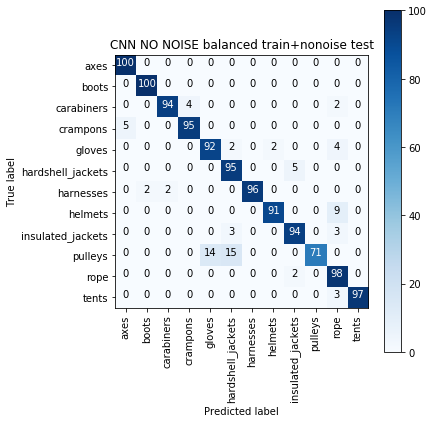

In [737]:
CNNEvaluate(model,X_test_bal,y_test_bal, title='CNN NO NOISE balanced train+nonoise test')

The CNN on the balanced noisy data works very well indeed - almost a perfect result, demonstrating the power of being able to learn invariant spatial features between pixels. The best classical approach was .69f1 and this improves it significantly to .94f1

Now we are going to simulate a real-world scenario and apply random mutations to the images before splitting and training

First we use some boilerplate code to handle the augmentation

We will select out 10000 images which is the upper limit of what you could expect to use on a classical algorithm but enough to allow the CNN to learn well in respect of the augmentation

In [621]:
%%time

import random

from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=0.1,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     fill_mode="constant",
                     cval=1)

image_datagen = ImageDataGenerator(**data_gen_args)

@Pipe
def augmentation(flow):

    for x in flow:
        trans = image_datagen.get_random_transform( (128,128) )
        yield ( x[0], image_datagen
                       .apply_transform(
                           x[1].reshape(128,128,1), trans
                        ).reshape(128,128) )

augmented_flow = balancedSignalGenerator(X,y) | augmentation | take(10000) | as_list

X_bal_aug = augmented_flow | select(lambda el: el[1]) | as_list | as_npy
y_bal_aug = augmented_flow | select(lambda el: el[0]) | as_list | as_npy

X_bal_aug_noise = noiseImages(X_bal_aug)

Wall time: 1min 8s


Let's see what the results are

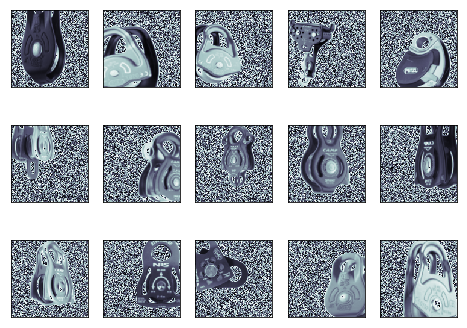

In [622]:
plotSome(X_bal_aug_noise, y_bal_aug, name="pulleys")

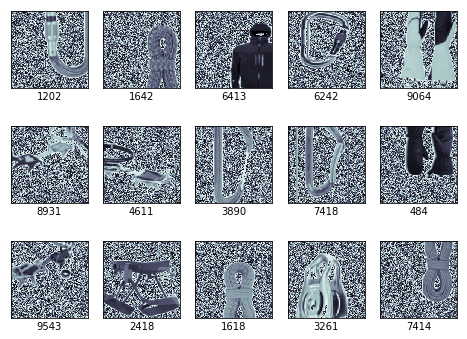

In [624]:
plot16(X_bal_aug_noise, rand=True)

OK, we have a pretty cool dataset here now - which resembles real life conditions. The hypothesis on the table is that the trees algorithm gets near to zero accuracy, Let's see.

First let's split the data. Note that now we are augmenting, it's no longer cheating to split *after* the augmenting because we can think of them as being unique images i.e. the same thing from a different angle

In [625]:
from sklearn.model_selection import train_test_split

X_train_bal_aug_noise, X_test_bal_aug_noise, y_train_bal_aug_noise, y_test_bal_aug_noise \
    = train_test_split(X_bal_aug_noise, y_bal_aug, random_state=0)

print(X_train_bal_aug_noise.shape, X_test_bal_aug_noise.shape)

(7500, 128, 128) (2500, 128, 128)


                   precision    recall  f1-score   support

             axes       0.17      0.18      0.18       195
            boots       0.15      0.14      0.14       216
       carabiners       0.11      0.10      0.11       206
         crampons       0.12      0.11      0.12       213
           gloves       0.21      0.19      0.20       198
hardshell_jackets       0.21      0.20      0.21       211
        harnesses       0.07      0.08      0.08       208
          helmets       0.08      0.09      0.08       197
insulated_jackets       0.29      0.27      0.28       220
          pulleys       0.14      0.14      0.14       204
             rope       0.12      0.13      0.13       222
            tents       0.16      0.17      0.16       210

      avg / total       0.15      0.15      0.15      2500

Wall time: 3min 2s


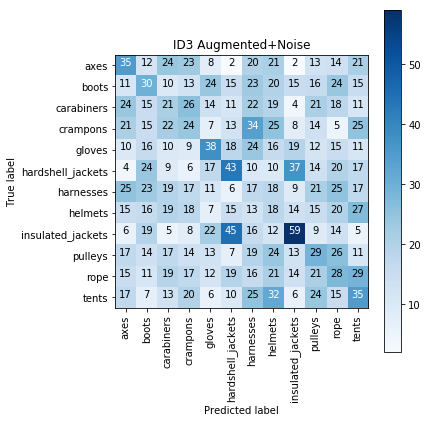

In [62]:
%%time
y_pred = ID3(
            flattenImage(X_train_bal_aug_noise), 
            flattenImage(X_test_bal_aug_noise), 
            y_train_bal_aug_noise, 
            y_test_bal_aug_noise
            )

plotConfusion(y_test_bal_aug_noise, y_pred, title='ID3 Augmented+Noise')

The next assertion is that PCA will no longer help us as the images are not aligned in space let's see

In [650]:
%%time

from sklearn import decomposition

X_train_bal_aug_noise_hog = computeHogFeatures(X_train_bal_aug_noise)
X_test_bal_aug_noise_hog = computeHogFeatures(X_test_bal_aug_noise)

X_train_bal_aug_noise_hog_pca, X_test_bal_aug_noise_hog_pca = \
    PCA(X_train_bal_aug_noise_hog, X_test_bal_aug_noise_hog, flat_size=8100)

Wall time: 27.8 s


Let's run SVM on the PCA transform from augmented+noise+PCA

                   precision    recall  f1-score   support

             axes       0.35      0.92      0.50       195
            boots       0.77      0.59      0.67       216
       carabiners       0.25      0.30      0.27       206
         crampons       0.31      0.29      0.30       213
           gloves       0.76      0.59      0.67       198
hardshell_jackets       0.39      0.39      0.39       211
        harnesses       0.56      0.41      0.47       208
          helmets       0.58      0.44      0.50       197
insulated_jackets       0.48      0.50      0.49       220
          pulleys       0.52      0.31      0.39       204
             rope       0.35      0.34      0.35       222
            tents       0.49      0.32      0.39       210

      avg / total       0.48      0.45      0.45      2500



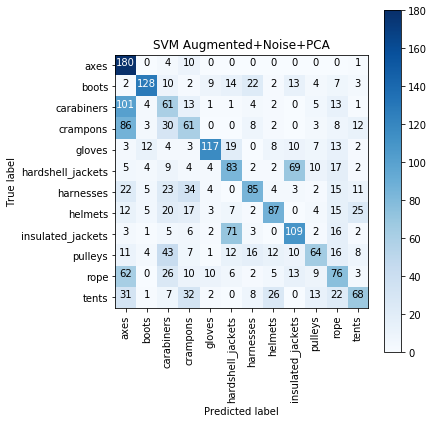

In [654]:
X_train_bal_aug_noise_pca, X_test_bal_aug_noise_pca = \
    PCA(X_train_bal_aug_noise, X_test_bal_aug_noise)

preds, model = SVM(
    X_train_bal_aug_noise_pca,
    X_test_bal_aug_noise_pca,
    y_train_bal_aug_noise,
    y_test_bal_aug_noise, 
    title='SVM Augmented+Noise+PCA'  )

Let's run SVM on the PCA transform from augmented+noise+hog

                   precision    recall  f1-score   support

             axes       0.28      0.99      0.44       195
            boots       0.49      0.59      0.54       216
       carabiners       0.65      0.30      0.41       206
         crampons       0.51      0.45      0.48       213
           gloves       0.34      0.30      0.32       198
hardshell_jackets       0.45      0.58      0.51       211
        harnesses       0.78      0.31      0.44       208
          helmets       0.37      0.58      0.45       197
insulated_jackets       0.63      0.35      0.45       220
          pulleys       0.36      0.20      0.25       204
             rope       0.53      0.12      0.19       222
            tents       0.40      0.27      0.32       210

      avg / total       0.49      0.42      0.40      2500

Wall time: 7.35 s


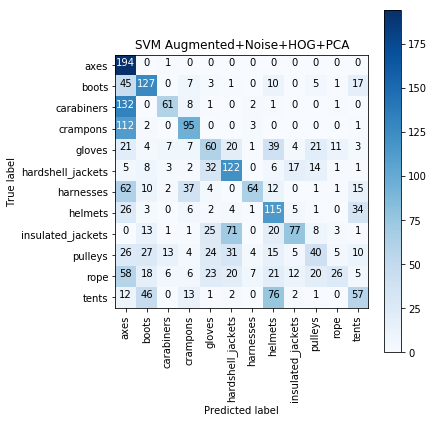

In [655]:
%%time

preds, model = SVM(
    X_train_bal_aug_noise_hog_pca,
    X_test_bal_aug_noise_hog_pca,
    y_train_bal_aug_noise,
    y_test_bal_aug_noise, 
    title='SVM Augmented+Noise+HOG+PCA'  )

PCA is not helping us like it did before, originally we went from about 0.28 on ID3 (trees) with balanced training labels and noise added to about .67 with PCA+SVM. Here we jump just .1 on average f-1 and as you can see from the confusion matrix it seems to think everything is axes and isn't doing well at all! It is doing well on gloves and boots and this might just be because they are not augmenting well?

Now let's try the CNN again on the augmented data, we are expecting it to be significantly better

Train on 7500 samples, validate on 2500 samples
Epoch 1/40
7500/7500 [==============================] - 3s 434us/step - loss: 2.3301 - acc: 0.1789 - val_loss: 2.0423 - val_acc: 0.2876
Epoch 2/40
7500/7500 [==============================] - 3s 354us/step - loss: 1.8986 - acc: 0.3417 - val_loss: 1.7262 - val_acc: 0.4044
Epoch 3/40
7500/7500 [==============================] - 3s 357us/step - loss: 1.6181 - acc: 0.4445 - val_loss: 1.5430 - val_acc: 0.4664
Epoch 4/40
7500/7500 [==============================] - 3s 356us/step - loss: 1.4345 - acc: 0.5133 - val_loss: 1.3873 - val_acc: 0.5272
Epoch 5/40
7500/7500 [==============================] - 3s 357us/step - loss: 1.2197 - acc: 0.5981 - val_loss: 1.2388 - val_acc: 0.5884
Epoch 6/40
7500/7500 [==============================] - 3s 356us/step - loss: 1.0933 - acc: 0.6365 - val_loss: 1.1315 - val_acc: 0.6204
Epoch 7/40
7500/7500 [==============================] - 3s 356us/step - loss: 0.9425 - acc: 0.6900 - val_loss: 1.0567 - val_acc: 0.6500


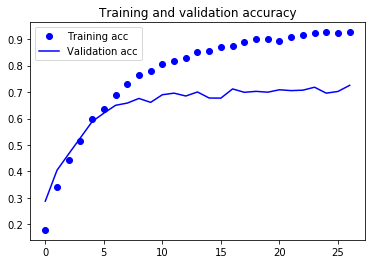

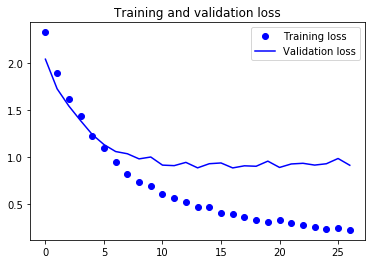

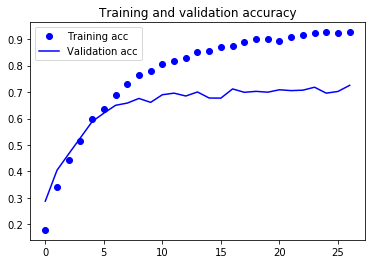

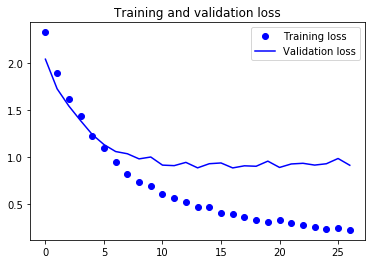

In [668]:
history, model2 = runCNNModel(
    X_train_bal_aug_noise,
    X_test_bal_aug_noise,
    y_train_bal_aug_noise,
    y_test_bal_aug_noise, epochs=40, batchsize=200, dropout=0.65)

plotHistory(history)

                   precision    recall  f1-score   support

             axes       0.81      0.94      0.87       195
            boots       0.83      0.86      0.84       216
       carabiners       0.72      0.71      0.71       206
         crampons       0.91      0.70      0.80       213
           gloves       0.59      0.59      0.59       198
hardshell_jackets       0.56      0.67      0.61       211
        harnesses       0.67      0.74      0.70       208
          helmets       0.75      0.79      0.77       197
insulated_jackets       0.62      0.52      0.57       220
          pulleys       0.67      0.53      0.59       204
             rope       0.62      0.60      0.61       222
            tents       0.79      0.91      0.85       210

      avg / total       0.71      0.71      0.71      2500



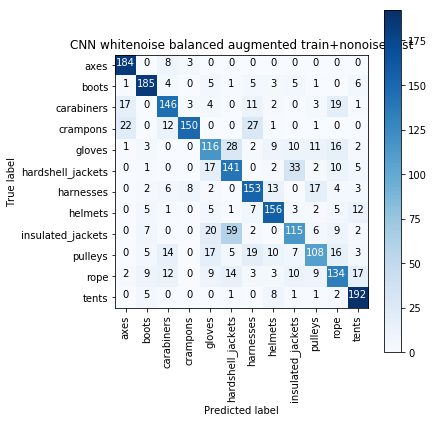

In [669]:

CNNEvaluate(model2, 
            X_test_bal_aug_noise,
            y_test_bal_aug_noise, 
            title='CNN whitenoise balanced augmented train+nonoise test')

The CNN achieves f1 of .71 on the augmented+noise data, a significant improvement on the .44 with augmented+noise+pca+SVM. Frankly I am extremely surprised the latter did as well as .44, I suspect if we augment more aggressively it will shoot down. 

The next frontier! LIME! We can use Lime to explain to us how our classifiers are working. Currently I am struggling to get it to work well so we will have to leave that for another day. 

Wall time: 8.91 s


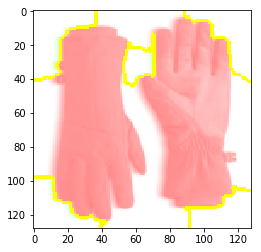

In [612]:
%%time

from lime import lime_image
import time
from keras.utils import to_categorical
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def predict_fn_id3(images):
    xf = flattenImage(images)
    xf = np.mean(xf,axis=2)
    xf = xf.reshape(xf.shape[0],xf.shape[1])
    return clf.predict_proba(xf)

def predict_fn_cnn(images):
    images = np.mean(images,axis=3)
    images = images.reshape(images.shape[0],128,128,1)
    return model.predict(images)

explanation = explainer.explain_instance(X_test[480], 
                                         predict_fn_cnn, 
                                         top_labels=12,
                                         hide_color=False, 
                                         num_samples=5000,
                                         num_features=100000,
                                         random_seed=42)

temp, mask = explanation.get_image_and_mask(imageTypes['gloves'], 
                                            positive_only=False, 
                                            num_features=100000, 
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))